# Analiza zbioru danych dotyczących smartfonów

Projekt ten ma na celu przeprowadzenie analizy eksploracyjnej oraz wykonanie regresji liniowej na zbiorze danych dotyczących smartfonów.

Link do zbioru: https://www.kaggle.com/datasets/swahajraza/a-dataset-of-smartphone-specifications-and-prices

# Analiza zbioru

## Import bibliotek

In [137]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Wczytanie zbioru

In [138]:
df = pd.read_csv('smartphone_specifications_and_prices.csv')

df

,brand_name,model,display,front_camera,rare_camera,processor,battery_capacity,ram,internal_storage,price
0,SAMSUNG,Samsung S24 Ultra,"6.8"" (120Hz)",40MP,108MP + 10MP + 10MP + 12MP,Exynos,5000 mAh,8.0,128,334999.0
1,SAMSUNG,Samsung S24 Plus,"6.6"" (120Hz)",10MP,50MP + 10MP + 12MP,Exynos,4500 mAh,8.0,128,189999.0
2,SAMSUNG,Samsung Zero,"6.41"" (120Hz)",32 MP,12 MP + 8 MP + 12 MP,Snapdragon 888 5G,4500 mAh,8.0,256,112999.0
3,SAMSUNG,Samsung S24,"6.1"" (120Hz)",10MP,50MP + 10MP + 12MP,Exynos,3700 mAh,8.0,128,249999.0
4,SAMSUNG,Samsung A05s,"6.5"" (90Hz)",5MP,50MP + 2MP + 2MP,Exynos,5000 mAh,4.0,64,24999.0
...,...,...,...,...,...,...,...,...,...,...
1251,OPPO,Oppo A37,"5.0""",5 MP,8 MP,Snapdragon 410,2630mAh,2.0,16,88415.0
1252,OPPO,Oppo F1,"5.0""",8 MP,13 MP,Snapdragon 616,-,3.0,16,35999.0
1253,OPPO,Oppo A31,"4.5""",5 MP,8 MP,Snapdragon 410,2000mAh,1.0,8,88415.0
1254,OPPO,Oppo Reno 4 SE,"6.43""",32 MP,48 MP + 8 MP + 2 MP,Dimensity 720,4300mAh,8.0,128,88415.0


## Oczyszczanie danych

**Stare** Ze względu na wiedzę a-priori związaną z tematem kamer, można stwierdzić, że sama informacja o ilości Mega Pixeli (MP) nie stanowi wyznacznika jakości kamer, również ich ilość, dlatego nie będę ich uwzględniał

Zamiana atrybutu opisowego *rear_camera* na atrybuty ilościowe. Rozdzielenie atrybututu *rear_camera* na *main_camera* - główny obiektyw, *sum_MP* - sumę megapikseli matryc, i *num_cameras* - liczbę obiektywów.

In [139]:
def count_integers(s):
    '''
    funkcja zwraca ilość wystąpień cyfr <= 200
    w ciągu oraz ich sumę liczb <= 200
    '''
    # Split the string into words
    words = re.findall(r'\d+', s)
    # Checking for the mistakes in data (> 200 MP)
    i = 0
    sum = 0
    for w in words:
        if int(w) > 200:                # ze względu na błędy w danych
            i = i - 1
        else:
            sum = sum + int(w)
    # Count the words that are numbers
    ret = len(words) + i
    return pd.Series([ret, sum])

In [140]:
df[['num_cameras', 'sum_MP']] = df['rare_camera'].apply(count_integers)

In [141]:
def find_first_number(s):
    ''' 
    funkcja zwraca pierwszą napotkaną liczbę
    w ciągu znaków
    '''
    words = re.findall(r'\d+', s)
    if len(words) > 0:
        return words[0]
    else:
        return 0

In [142]:
df['front_camera'] = df['front_camera'].apply(find_first_number)
df['main_camera']  = df['rare_camera'].apply(find_first_number)

df[['front_camera', 'main_camera']] = df[['front_camera', 'main_camera']].apply(pd.to_numeric)

# nie potrzebny już atrybut
df = df.drop(columns = 'rare_camera')

Usunięcie kolumn, które nie posiadały żadnych zgodnych liczb

In [143]:
df = df[df.front_camera != 0]
df = df[df.sum_MP != 0]
df = df[df.main_camera != 0]

In [144]:
# do usunięcia

#df['front_camera'] = pd.DataFrame(df['front_camera'].str.split('MP').tolist(), index = df.index)
print(df['front_camera'])

0       40
1       10
2       32
3       10
4        5
        ..
1251     5
1252     8
1253     5
1254    32
1255    32
Name: front_camera, Length: 1239, dtype: int64


Obrobienie wartości pojemności baterii - tylko te rekordy, które zawierają 4 cyfrową liczbę. Jest tak, ponieważ pojemności baterii zwyczajowo dla smartfonów podaje się w tysiącach mAh, pozostałe wartości, albo są nie podane, albo są podane w Wh i dotyczą tabletów

In [145]:
df = df[(df['battery_capacity'].str.contains(pat = '\d\d\d\d', regex= True))]

df['battery_capacity'] = pd.to_numeric(df['battery_capacity'].str[-8:-3])

print("Liczba obiektów:", df.shape[0])

Liczba obiektów: 1227


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_8576\4251574446.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = df[(df['battery_capacity'].str.contains(pat = '\d\d\d\d', regex= True))]


Rozdzielenie atrybutu 'display' na rozmiar ekranu i jego częstotliwość odświeżania. Jeżeli częstotliwość nie została podana 

In [146]:
# atrybut 'display' ma wartości podane jako: <liczba>" <ew. odświeżanie ekranu>
df[['screen_size', 'refresh_rate']] = pd.DataFrame(df['display'].str.split('"').tolist(), index = df.index)
df = df.drop(columns = 'display')

df['refresh_rate'] = df['refresh_rate'].apply(lambda x: '60' if x == ''  else x[2:-3])
print(df)

     brand_name                 model  front_camera          processor  \
0       SAMSUNG     Samsung S24 Ultra            40            Exynos    
1       SAMSUNG      Samsung S24 Plus            10            Exynos    
2       SAMSUNG          Samsung Zero            32  Snapdragon 888 5G   
3       SAMSUNG           Samsung S24            10            Exynos    
4       SAMSUNG          Samsung A05s             5            Exynos    
...         ...                   ...           ...                ...   
1250       OPPO              Oppo A57            16     Snapdragon 435   
1251       OPPO              Oppo A37             5     Snapdragon 410   
1253       OPPO              Oppo A31             5     Snapdragon 410   
1254       OPPO        Oppo Reno 4 SE            32      Dimensity 720   
1255       OPPO  Oppo Reno 4 SE 256GB            32      Dimensity 720   

      battery_capacity  ram  internal_storage     price  num_cameras  sum_MP  \
0                 5000  8.0    

## Podstawowe statystyki danych

In [147]:
# liczba obiektów
print("Liczba obiektów:", df.shape[0])
# liczba marek smartfonów
marki = df['brand_name'].unique()
print("Liczba marek:", marki.shape[0])
# liczba obiektów poszczególnych marek
for i in list(marki):
    print("Obiektów marki", i, ": ", len(df[df['brand_name'] == i]))
# liczba atrybutów
print("Liczba atrybutów:", df.shape[1])
# liczba braków
print("Ilość braków:", df.isnull().sum().sum())

Liczba obiektów: 1227
Liczba marek: 5
Obiektów marki SAMSUNG :  399
Obiektów marki XIAOMI :  393
Obiektów marki APPLE :  134
Obiektów marki ONEPLUS :  84
Obiektów marki OPPO :  217
Liczba atrybutów: 13
Ilość braków: 9


Usuwanie obiektów z brakami

In [148]:
df.dropna(axis = 'rows')

,brand_name,model,front_camera,processor,battery_capacity,ram,internal_storage,price,num_cameras,sum_MP,main_camera,screen_size,refresh_rate
0,SAMSUNG,Samsung S24 Ultra,40,Exynos,5000,8.0,128,334999.0,4,140,108,6.8,120
1,SAMSUNG,Samsung S24 Plus,10,Exynos,4500,8.0,128,189999.0,3,72,50,6.6,120
2,SAMSUNG,Samsung Zero,32,Snapdragon 888 5G,4500,8.0,256,112999.0,3,32,12,6.41,120
3,SAMSUNG,Samsung S24,10,Exynos,3700,8.0,128,249999.0,3,72,50,6.1,120
4,SAMSUNG,Samsung A05s,5,Exynos,5000,4.0,64,24999.0,3,54,50,6.5,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,OPPO,Oppo A57,16,Snapdragon 435,2900,3.0,32,36999.0,1,13,13,5.2,60
1251,OPPO,Oppo A37,5,Snapdragon 410,2630,2.0,16,88415.0,1,8,8,5.0,60
1253,OPPO,Oppo A31,5,Snapdragon 410,2000,1.0,8,88415.0,1,8,8,4.5,60
1254,OPPO,Oppo Reno 4 SE,32,Dimensity 720,4300,8.0,128,88415.0,3,58,48,6.43,60


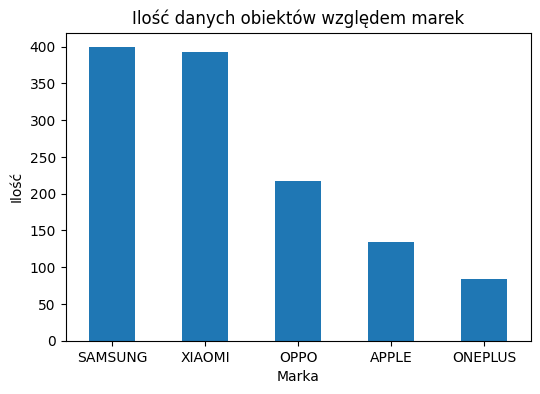

In [149]:
# wykres
plt.figure(figsize=(6, 4))
df['brand_name'].value_counts().sort_values(ascending = 0).plot(kind='bar', rot = 0)
plt.title('Ilość danych obiektów względem marek', fontsize = 12)
plt.xlabel('Marka', fontsize=10)
plt.ylabel('Ilość', fontsize=10)
plt.show()

Zbiór posiada 5 producentów smartfonów oraz nie posiada braków. Większość obiektów (smartfonów) jest marki SAMSUNG lub XIAOMI. Jednocześnie każdy smartfon posiada 6 atrybutów ilościowych: pamięć wewnętrzną, pamięć RAM, wielkość przekątnej ekranu, odświeżanie ekranu, pojemność baterii i cenę

*odświeżanie ekranu może być potraktowane jako atrybut kategoryczny porządkowy, ponieważ wartości odświeżania ekranu zwykle przyjmują wartości 60, 90, 120 Hz

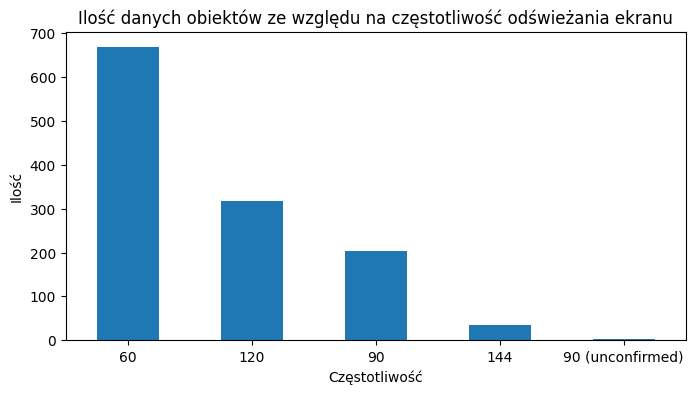

In [150]:
plt.figure(figsize=(8, 4))
df['refresh_rate'].value_counts().sort_values(ascending = 0).plot(kind='bar', rot = 0)
plt.title('Ilość danych obiektów ze względu na częstotliwość odświeżania ekranu', fontsize = 12)
plt.xlabel('Częstotliwość', fontsize=10)
plt.ylabel('Ilość', fontsize=10)
plt.show()

Pozbycie się informacji '(unconfirmed)' i '(international)' z atrybutów obiektów

In [151]:
df['refresh_rate'] = df['refresh_rate'].apply(lambda x: x[:2] if '(' in x  else x)

df[['screen_size', 'refresh_rate']] = df[['screen_size', 'refresh_rate']].apply(pd.to_numeric)

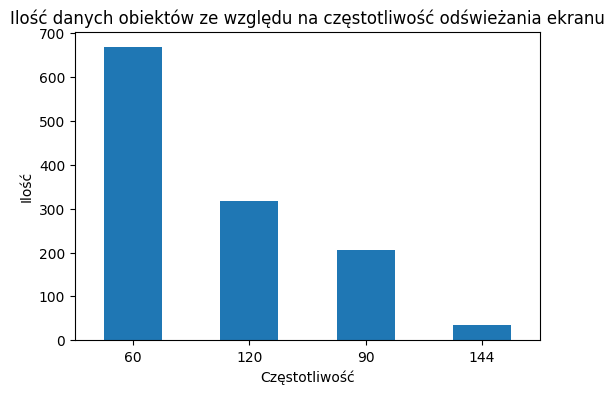

In [152]:
plt.figure(figsize=(6, 4))
df['refresh_rate'].value_counts().sort_values(ascending=0).plot(kind='bar', rot = 0)
plt.title('Ilość danych obiektów ze względu na częstotliwość odświeżania ekranu', fontsize = 12)
plt.xlabel('Częstotliwość', fontsize=10)
plt.ylabel('Ilość', fontsize=10)
plt.show()

## Wykresy pudełkowe i skrzypcowe dla danych

In [153]:
print(df)

     brand_name                 model  front_camera          processor  \
0       SAMSUNG     Samsung S24 Ultra            40            Exynos    
1       SAMSUNG      Samsung S24 Plus            10            Exynos    
2       SAMSUNG          Samsung Zero            32  Snapdragon 888 5G   
3       SAMSUNG           Samsung S24            10            Exynos    
4       SAMSUNG          Samsung A05s             5            Exynos    
...         ...                   ...           ...                ...   
1250       OPPO              Oppo A57            16     Snapdragon 435   
1251       OPPO              Oppo A37             5     Snapdragon 410   
1253       OPPO              Oppo A31             5     Snapdragon 410   
1254       OPPO        Oppo Reno 4 SE            32      Dimensity 720   
1255       OPPO  Oppo Reno 4 SE 256GB            32      Dimensity 720   

      battery_capacity  ram  internal_storage     price  num_cameras  sum_MP  \
0                 5000  8.0    

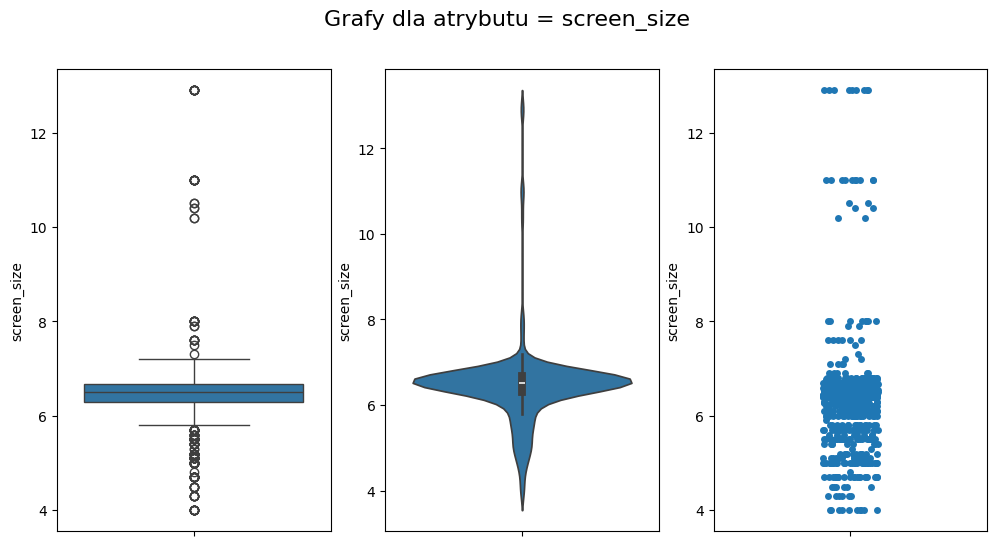

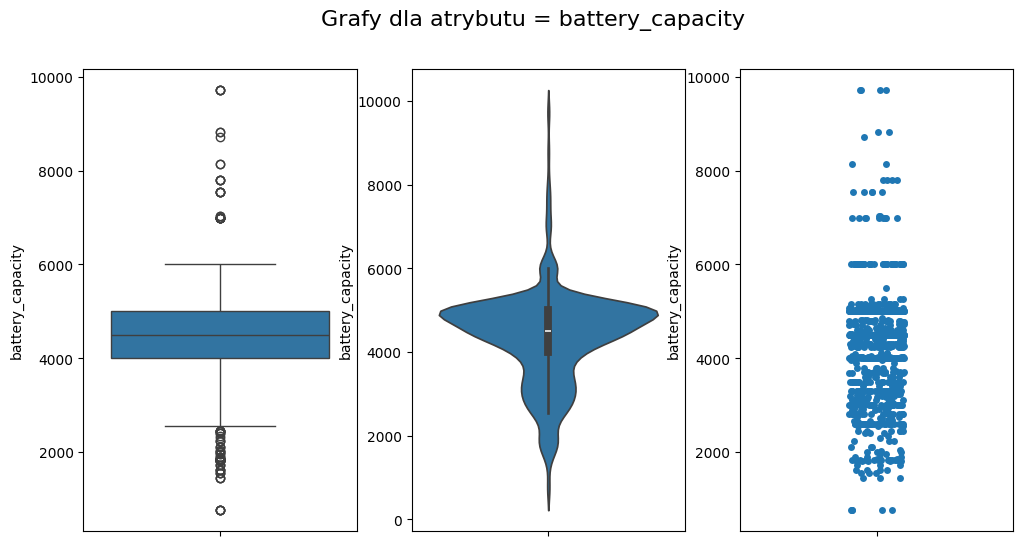

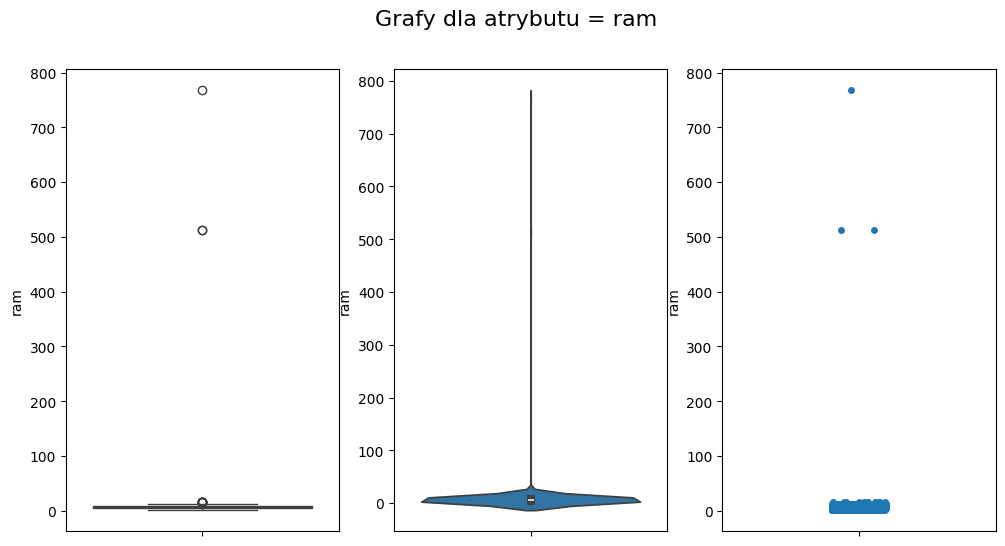

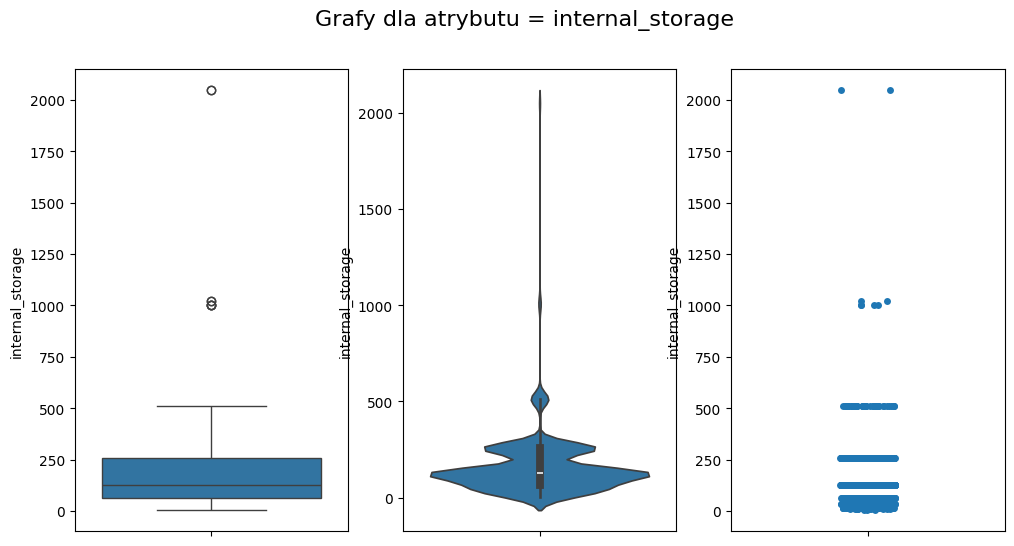

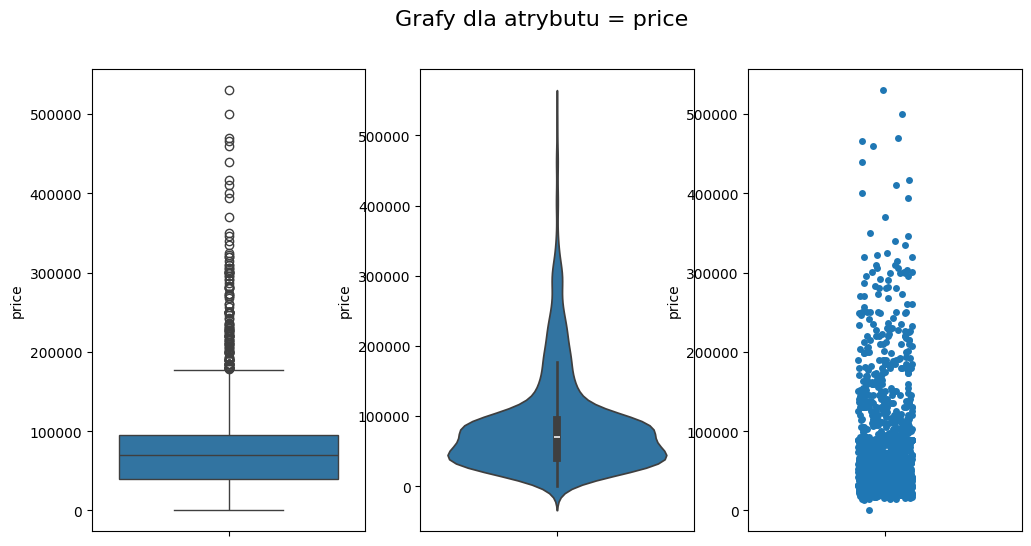

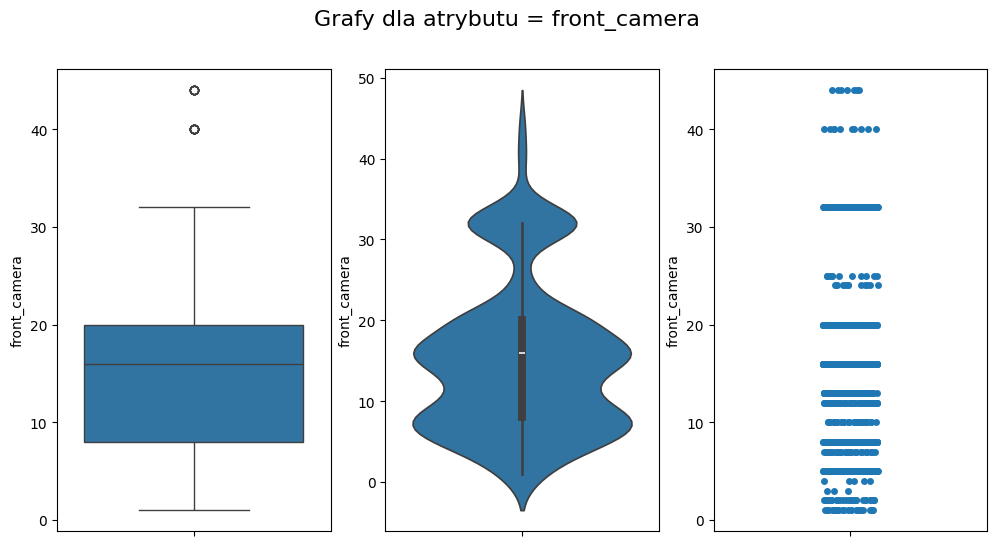

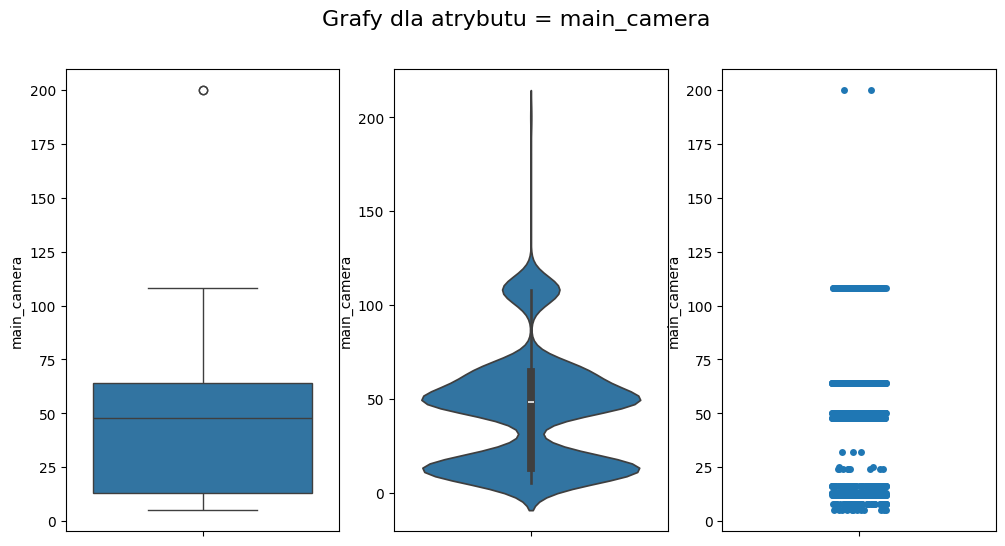

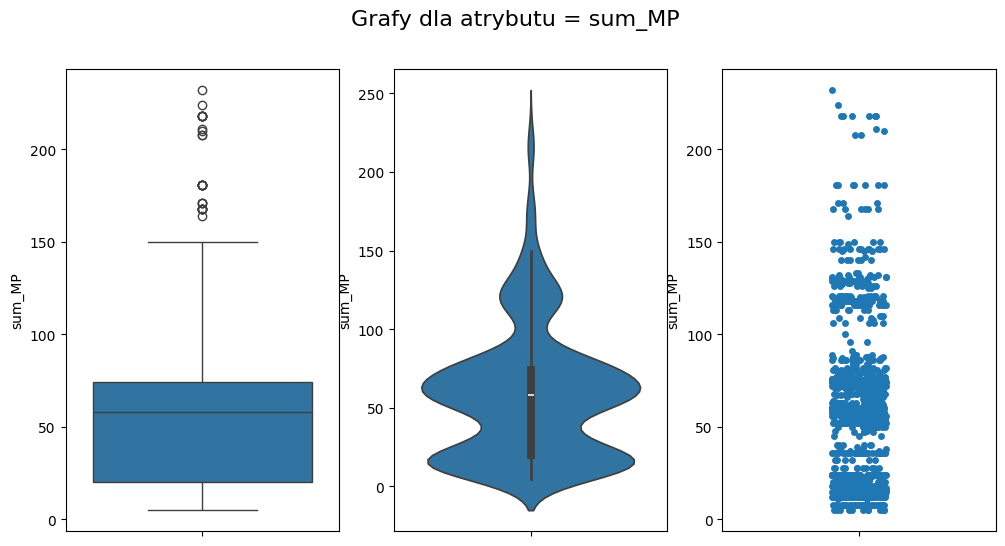

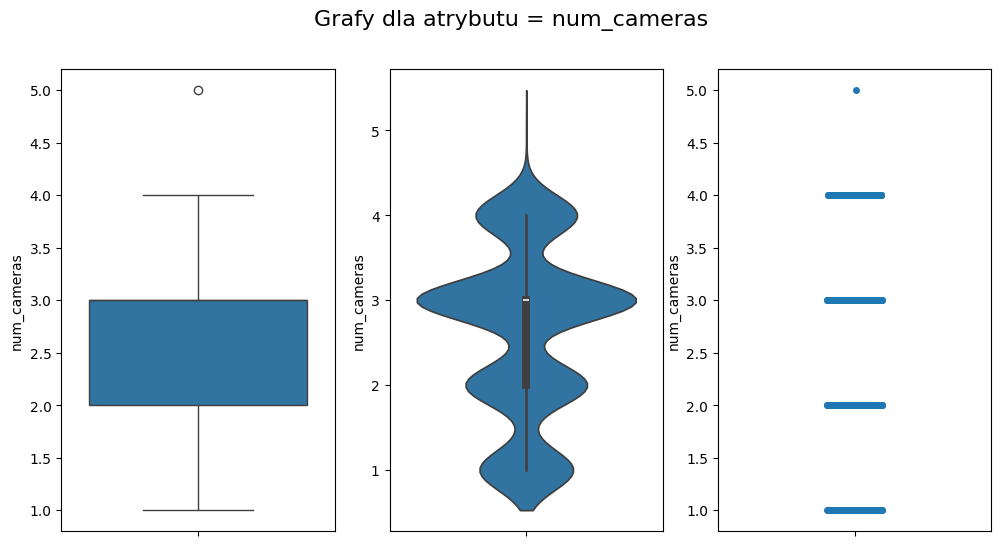

In [154]:
for attr in ['screen_size', 'battery_capacity', 'ram', 'internal_storage', 'price', 'front_camera', 'main_camera', 'sum_MP', 'num_cameras']:
    dane = df[attr]
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Grafy dla atrybutu = {attr}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.xticks(rotation=45, ha='right')
    sns.boxplot(data=dane)
    
    plt.subplot(1, 3, 2)
    plt.xticks(rotation=45, ha='right')
    sns.violinplot(data=dane)
    
    plt.subplot(1, 3, 3)
    plt.xticks(rotation=45, ha='right')
    sns.stripplot(data=dane)
    
    plt.show()

Usunięcie wartości odstających
Dla atrybutu 'screen size' będą to telefony o rozmiarze < 7 cali. Pozostałe modele są to albo tablety, albo smartfony składane, których wartości są zawyżone i błędy związane z niepoprawnymi wartościami pamięci RAM w zbiorze dostarczonych danych.

In [155]:
df = df[(df['screen_size'] < 7) & (df['screen_size'] > 4)]
df = df[df['ram'] < 100]
# df = df[df['internal_storage'] < 600]

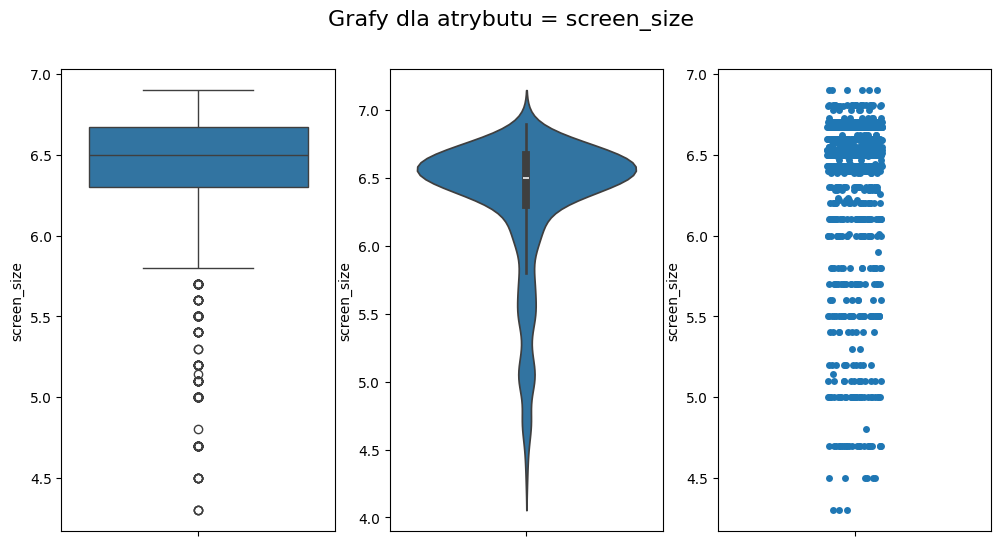

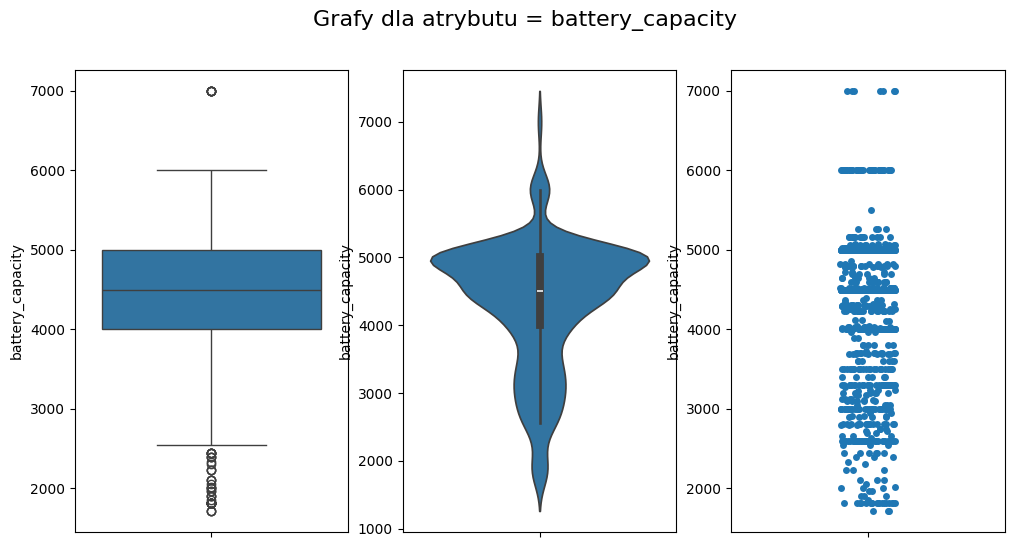

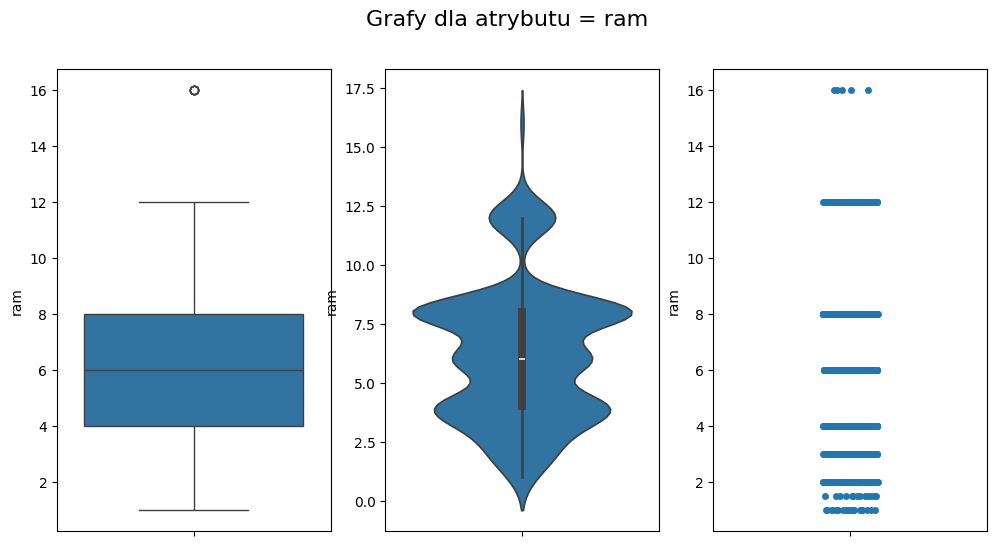

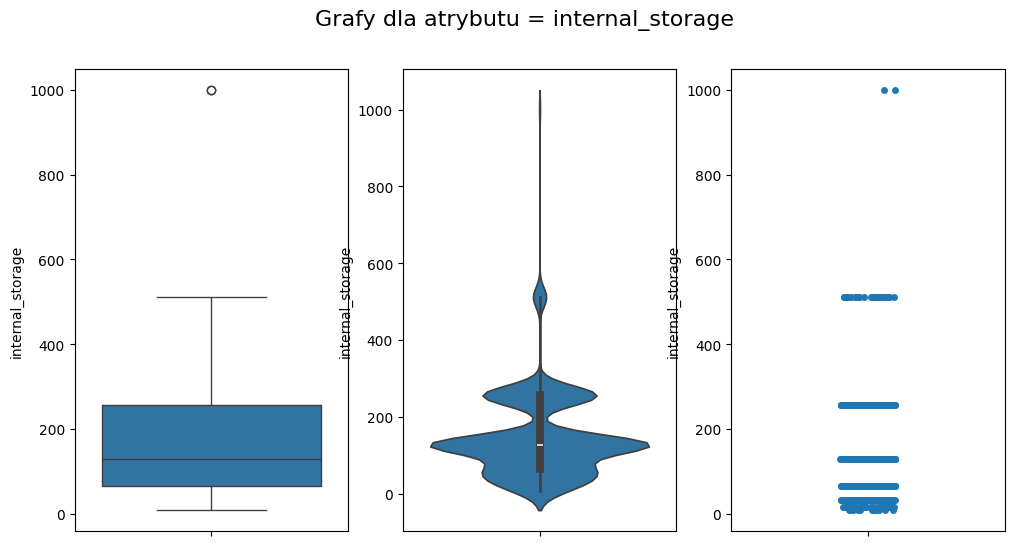

In [156]:
for attr in ['screen_size', 'battery_capacity', 'ram', 'internal_storage']:
    dane = df[attr]
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Grafy dla atrybutu = {attr}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.xticks(rotation=45, ha='right')
    sns.boxplot(data=dane)
    
    plt.subplot(1, 3, 2)
    plt.xticks(rotation=45, ha='right')
    sns.violinplot(data=dane)
    
    plt.subplot(1, 3, 3)
    plt.xticks(rotation=45, ha='right')
    sns.stripplot(data=dane)
    
    plt.show()

## Macierz wykresów atrybutów danych

In [157]:
#sns.pairplot(data = df, hue = 'brand_name')

Z powyższej macierzy można zauważyć, że marka APPLE charakteryzuje się mniejszymi pojemnościami baterii i trochę wyższą ceną niż pozostałe marki. Najprawdopodobniej jest to związane z użyciem przez nich własnego systemu operacyjnego, co może wskazywać na użycie osobnego modelu dla właśnie tych smartfonów. Również wśród produktów marki APPLE znajduje się najwięcje smartfonów o mniejszych rozmiarach ekranu.

## Macierz korelacji danych

<Axes: >

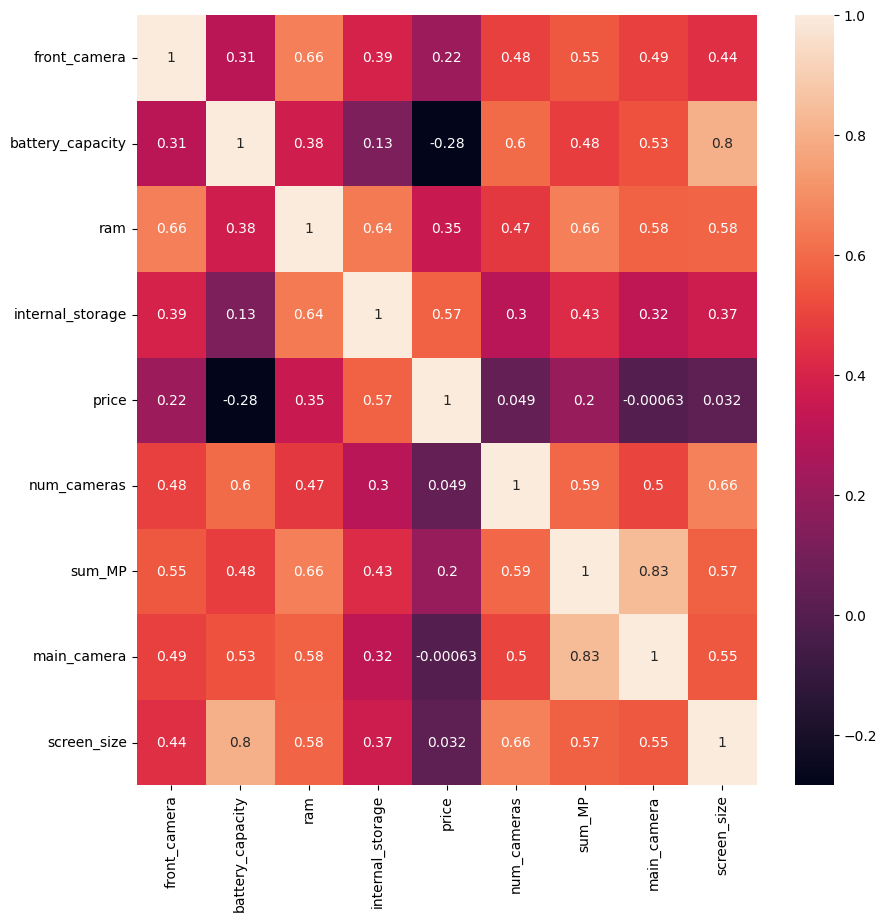

In [158]:
df

plt.figure(figsize=(10,10),dpi = 100)
sns.heatmap(df.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11]].corr(),annot = df.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11]].corr())

Największy wpływ na cenę ma pojemność pamięci wewnętrznej, choć nie jest to mocna korelacja 0,55. Najbradziej skorelowanymi atrybutami są rozmiar ekranu i pojemność baterii, co jest związane z fizycznym rozmiarem urządzenia. Również ciekawym jest to, że cena i pojemność baterii jest ze sobą ujemnie skorelowana, jest to najprawdopodobniej powiązane z użyciem produktów APPLE, które mają mniejszą pojemność baterii.

W tym przypadku atrybutami, które jako jedyne mają jakikolwiek wpływ są: *internal_storage*, *battery_capacity*, *front_camera*, *ram*

Z powodu na słabą korelację atrybutów między sobą i sugerowany wpływ różnic ze względu na smartfony firmy APPLE, myślę, że najlepszym sposobem do uzyskania dobrych rezultatów jest przeprowadzenie analizy jeszcze raz dla podziału na smartfony APPLE i resztę, czyli te z systemem Android

In [159]:
df_apple = df[df['brand_name'] == 'APPLE']
print(len(df_apple))

df_android = df[df['brand_name'] != 'APPLE']
print(len(df_android))

100
1065


Analiza dla smartfonów Android

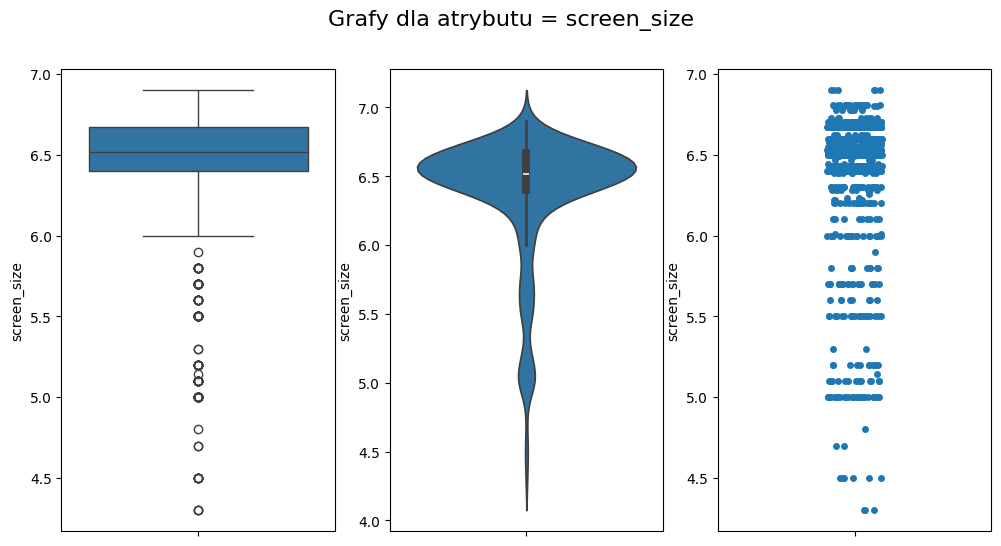

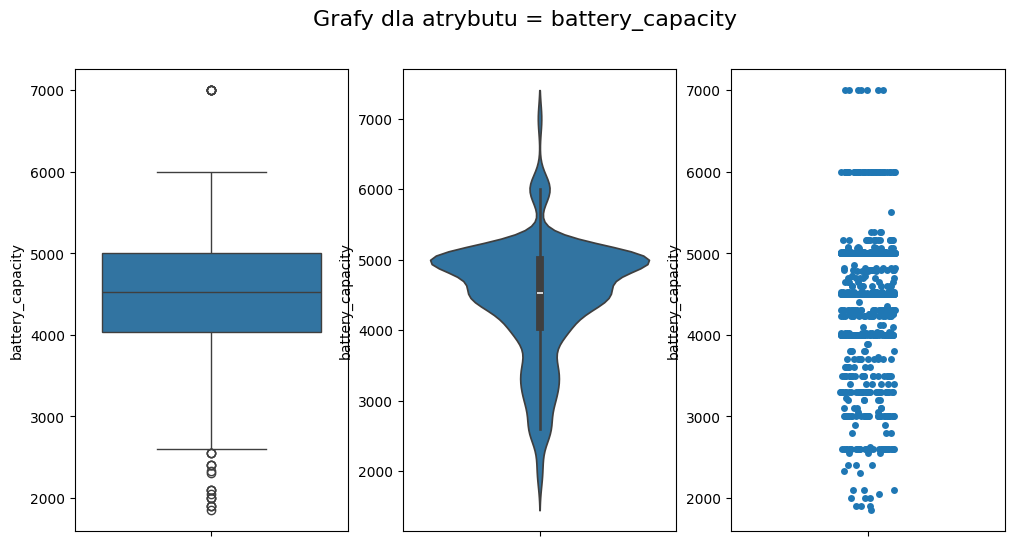

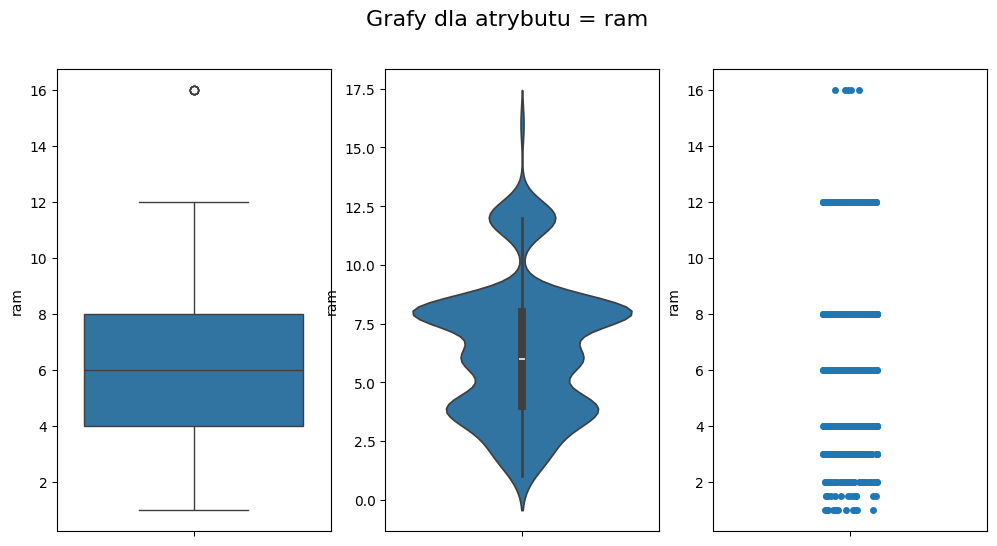

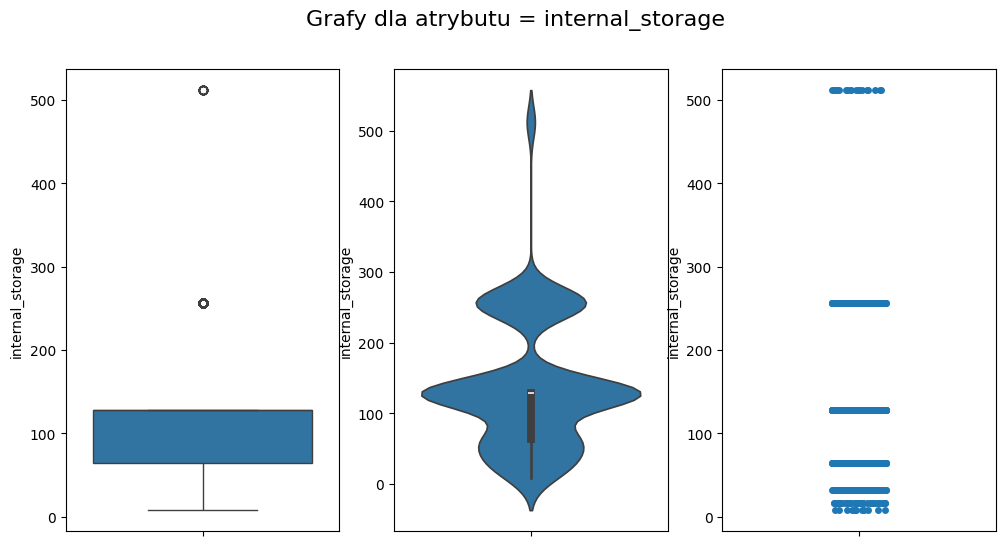

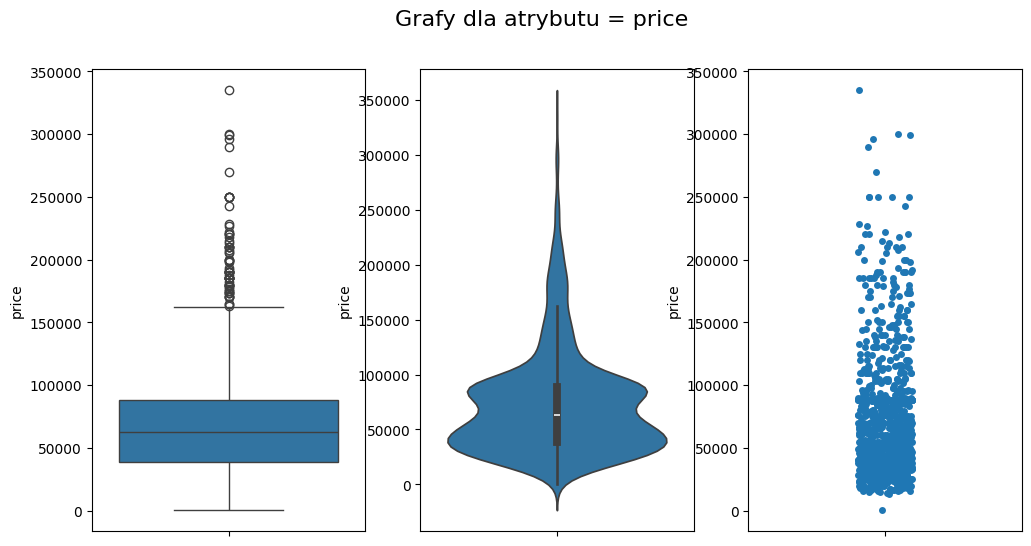

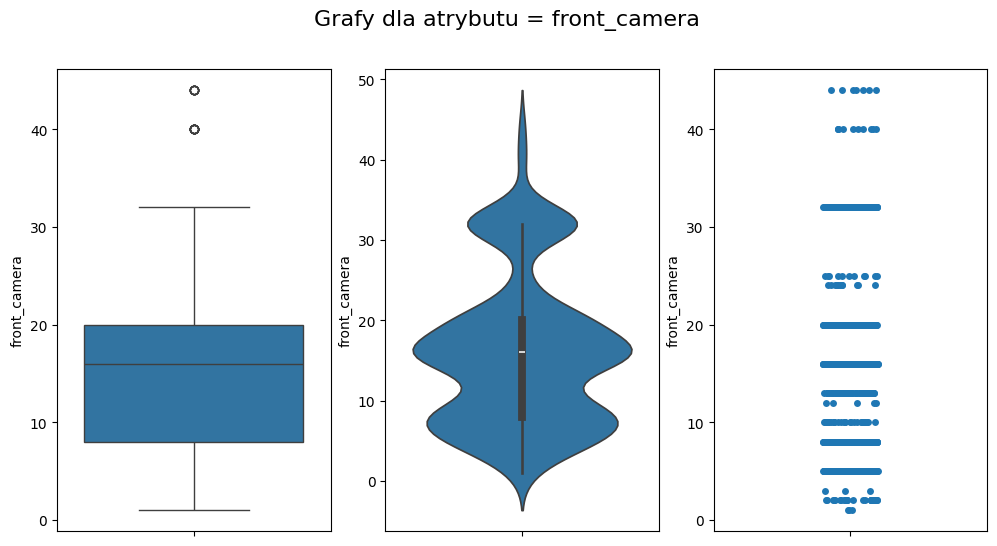

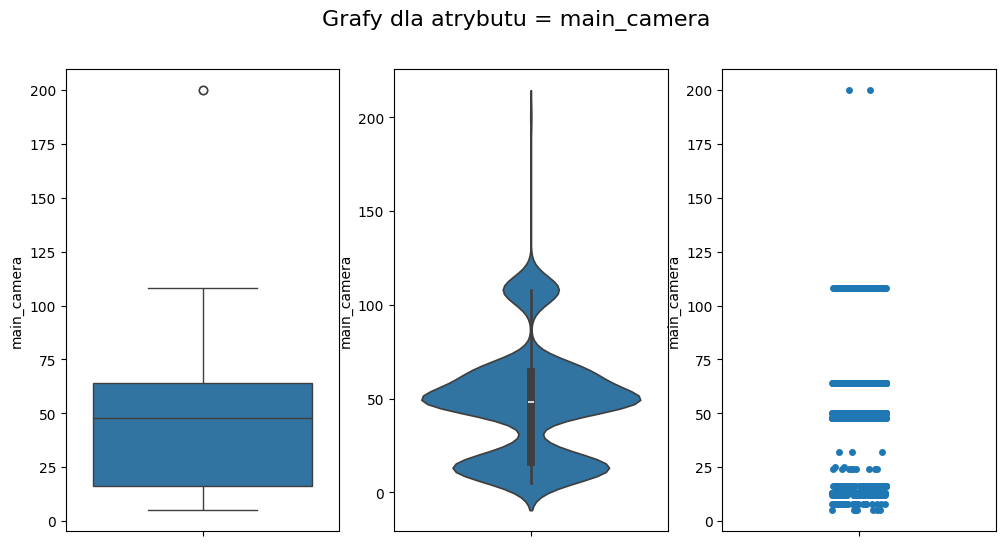

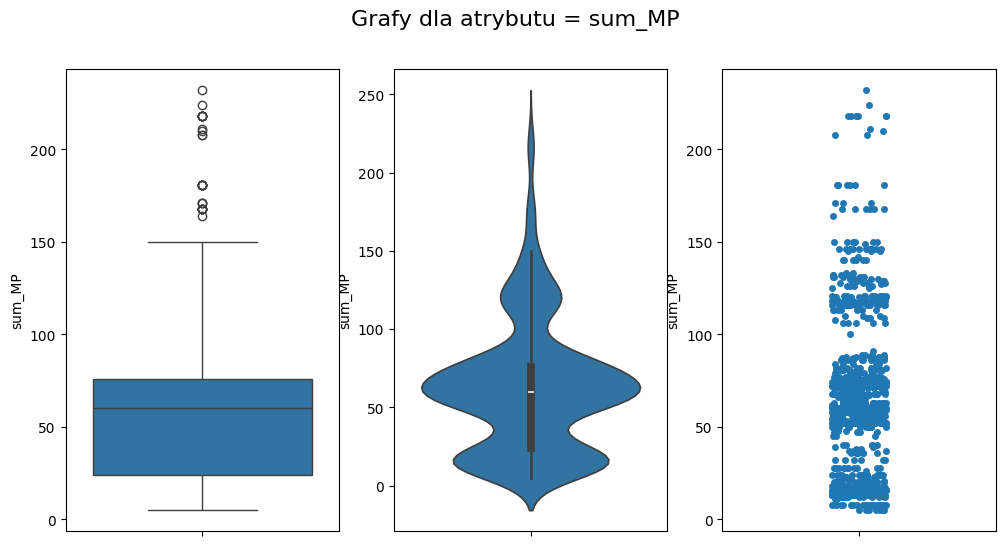

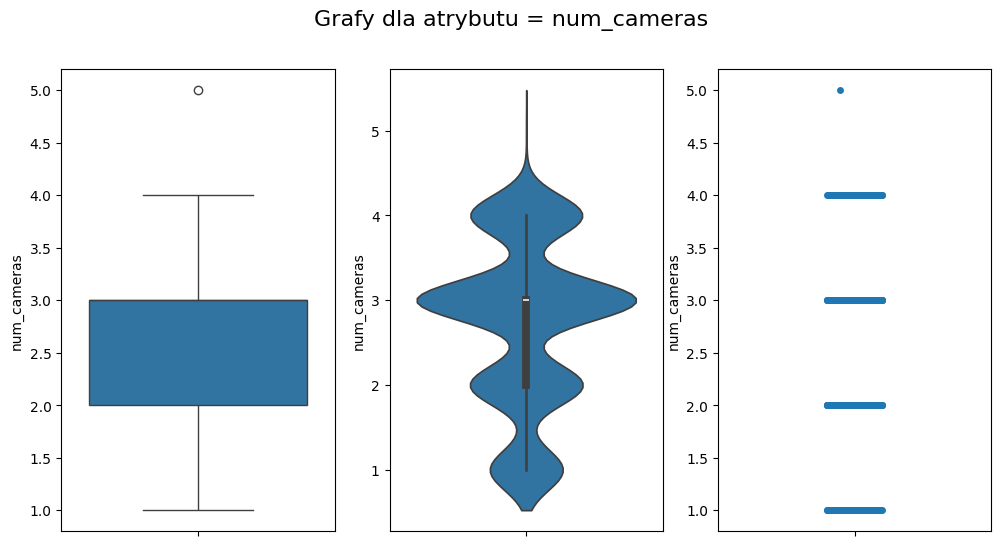

In [160]:
for attr in ['screen_size', 'battery_capacity', 'ram', 'internal_storage', 'price', 'front_camera', 'main_camera', 'sum_MP', 'num_cameras']:
    dane = df_android[attr]
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Grafy dla atrybutu = {attr}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.xticks(rotation=45, ha='right')
    sns.boxplot(data=dane)
    
    plt.subplot(1, 3, 2)
    plt.xticks(rotation=45, ha='right')
    sns.violinplot(data=dane)
    
    plt.subplot(1, 3, 3)
    plt.xticks(rotation=45, ha='right')
    sns.stripplot(data=dane)
    
    plt.show()

Usunięcie wartości odstających

In [161]:
df_android = df_android[df['screen_size'] > 5.5]
df_android = df_android[df['battery_capacity'] > 2500]

C:\Users\User\AppData\Local\Temp\ipykernel_8576\3772654079.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_android = df_android[df['screen_size'] > 5.5]
C:\Users\User\AppData\Local\Temp\ipykernel_8576\3772654079.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_android = df_android[df['battery_capacity'] > 2500]


Macierz korelacji

<Axes: >

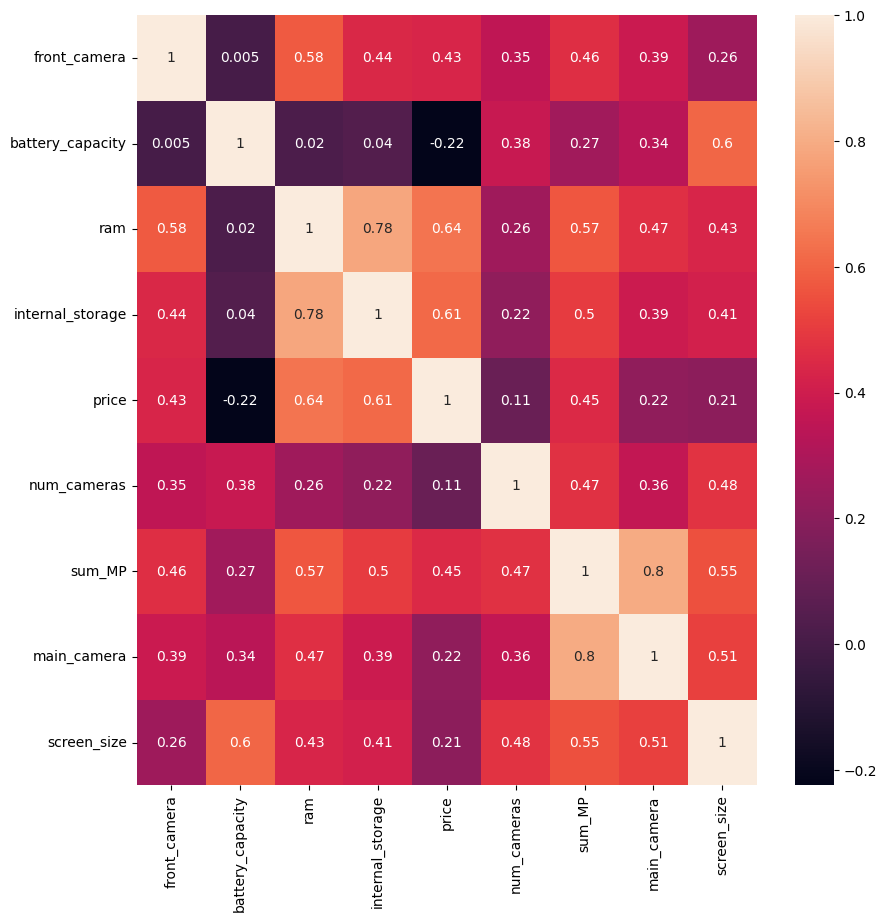

In [162]:
df

plt.figure(figsize=(10,10),dpi = 100)
sns.heatmap(df_android.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11]].corr(),annot = df_android.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11]].corr())

Dla smartfonów Apple

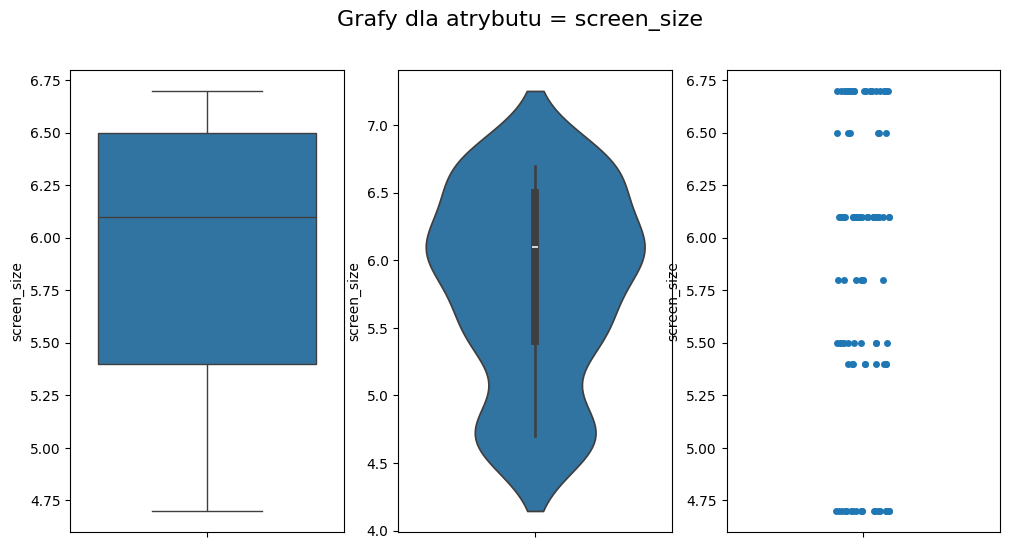

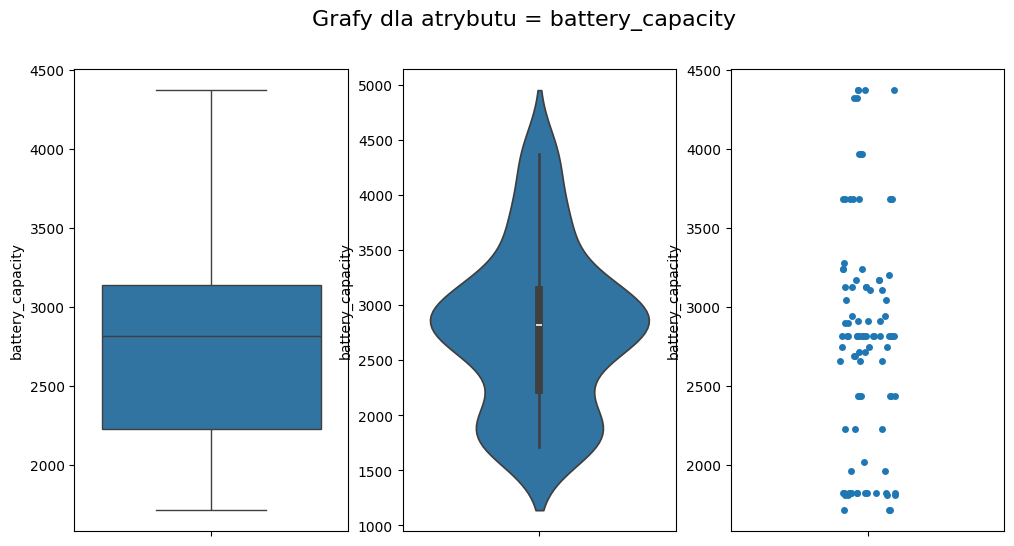

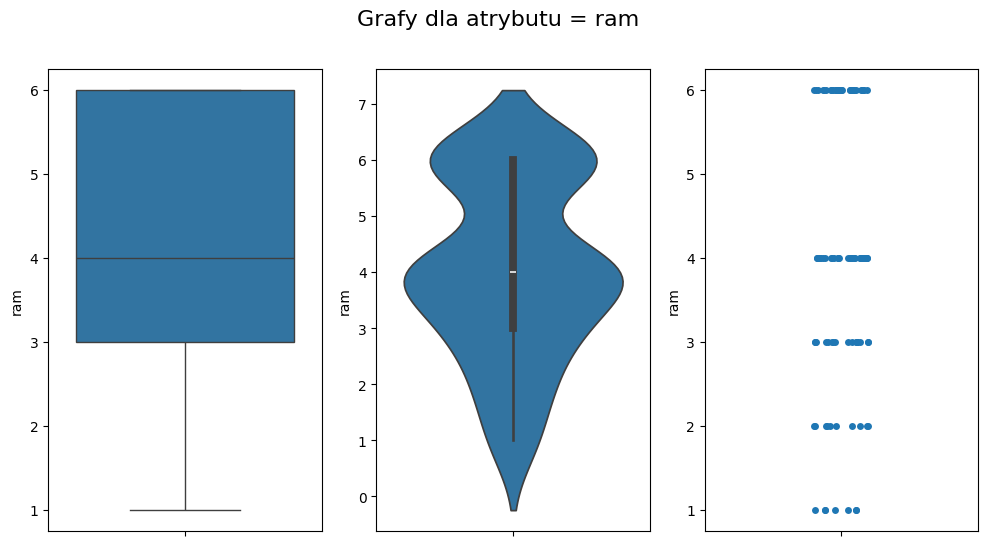

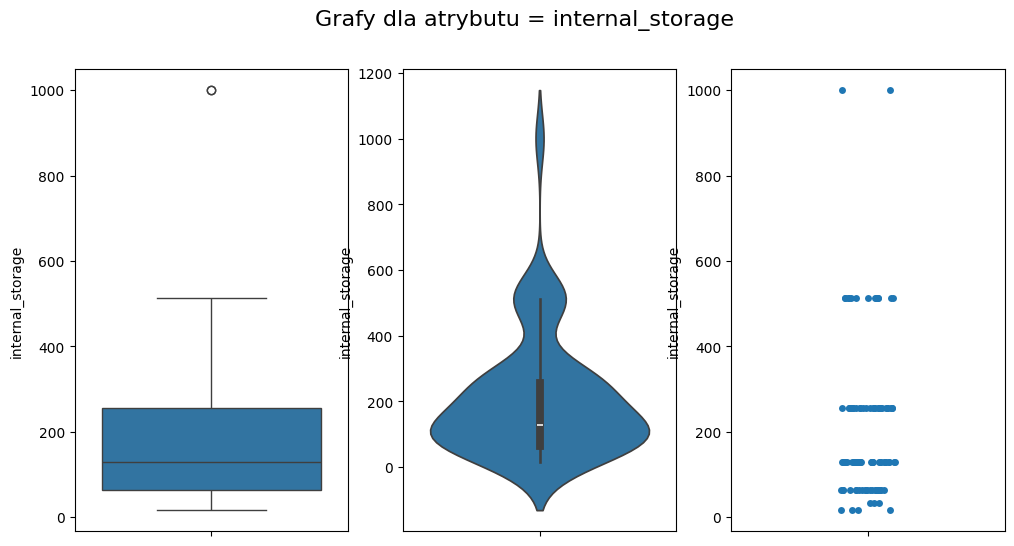

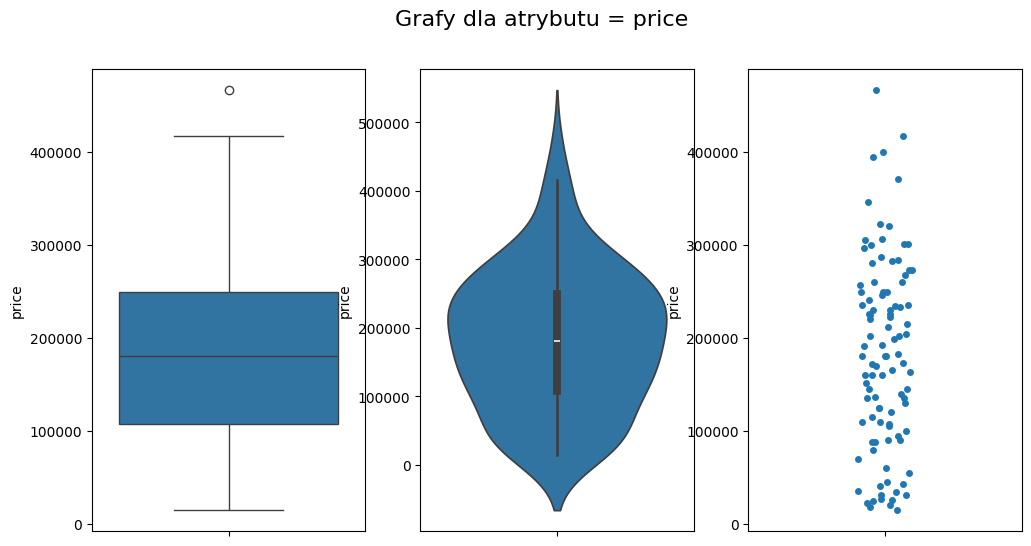

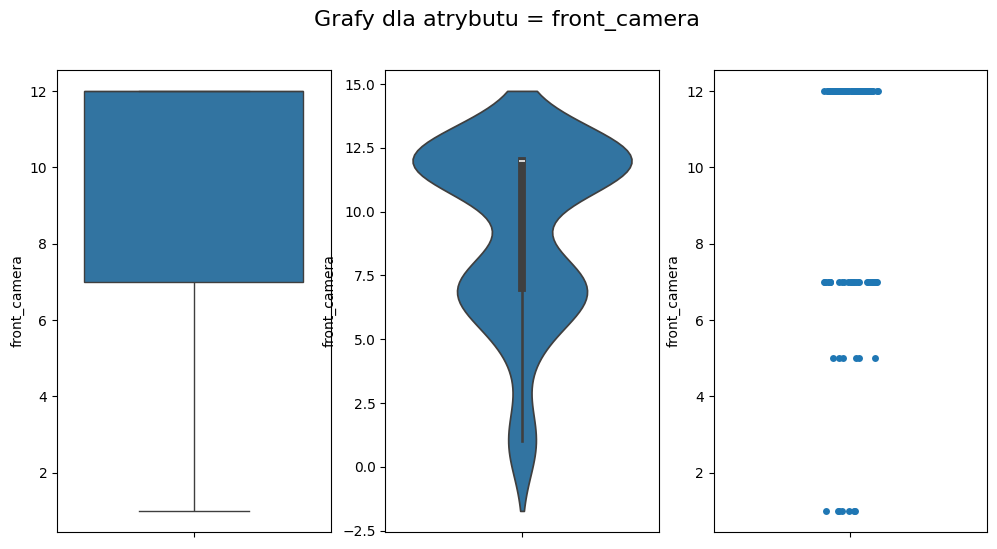

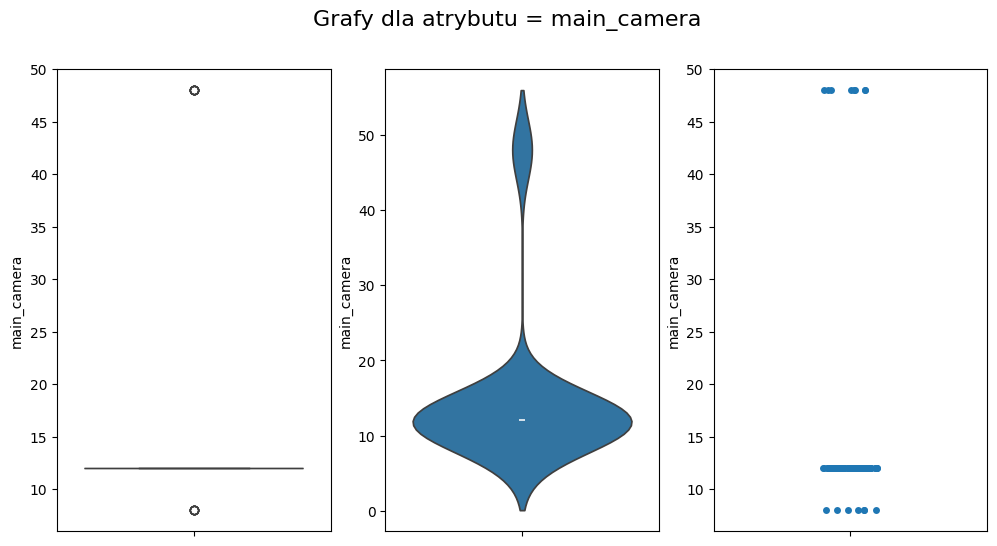

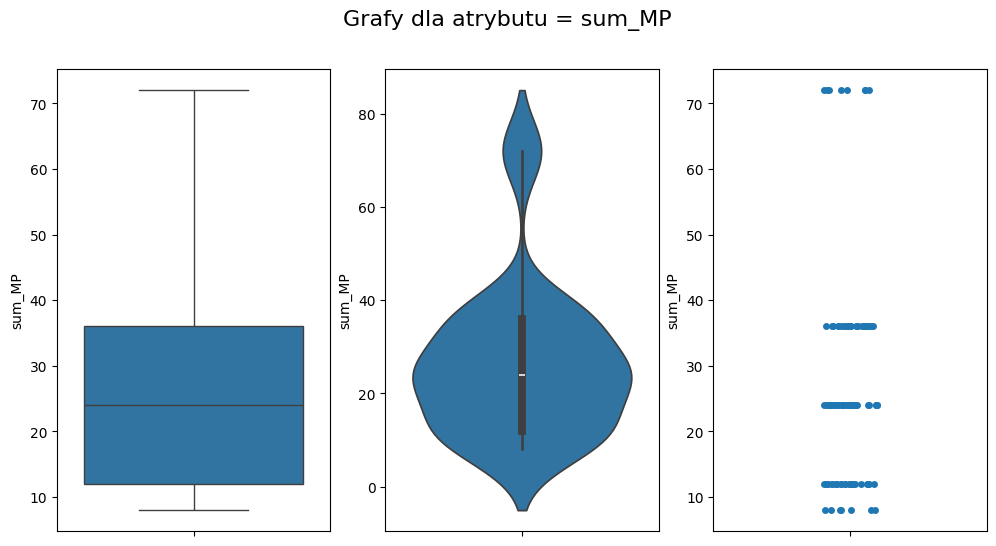

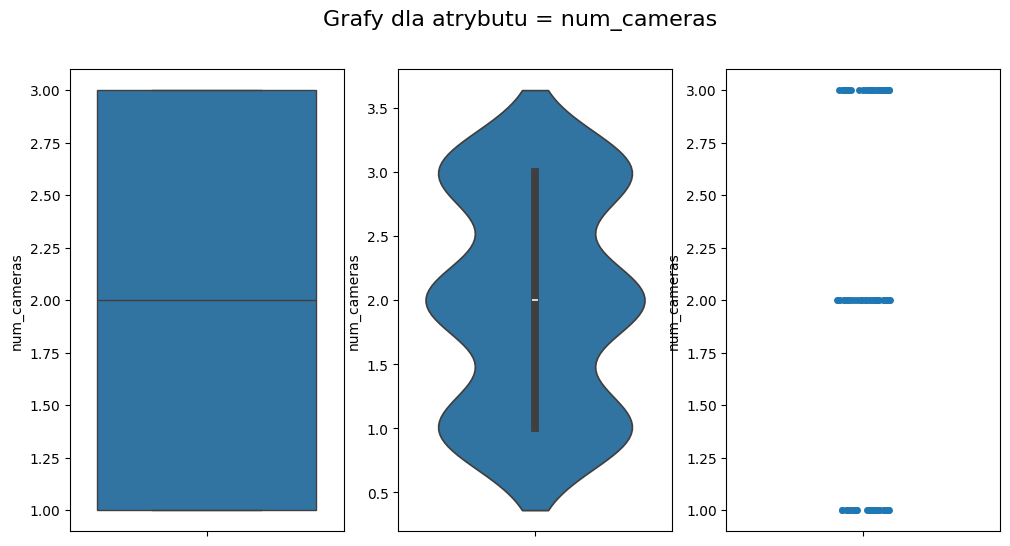

In [163]:
for attr in ['screen_size', 'battery_capacity', 'ram', 'internal_storage', 'price', 'front_camera', 'main_camera', 'sum_MP', 'num_cameras']:
    dane = df_apple[attr]
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Grafy dla atrybutu = {attr}', fontsize=16)
    
    plt.subplot(1, 3, 1)
    plt.xticks(rotation=45, ha='right')
    sns.boxplot(data=dane)
    
    plt.subplot(1, 3, 2)
    plt.xticks(rotation=45, ha='right')
    sns.violinplot(data=dane)
    
    plt.subplot(1, 3, 3)
    plt.xticks(rotation=45, ha='right')
    sns.stripplot(data=dane)
    
    plt.show()

<Axes: >

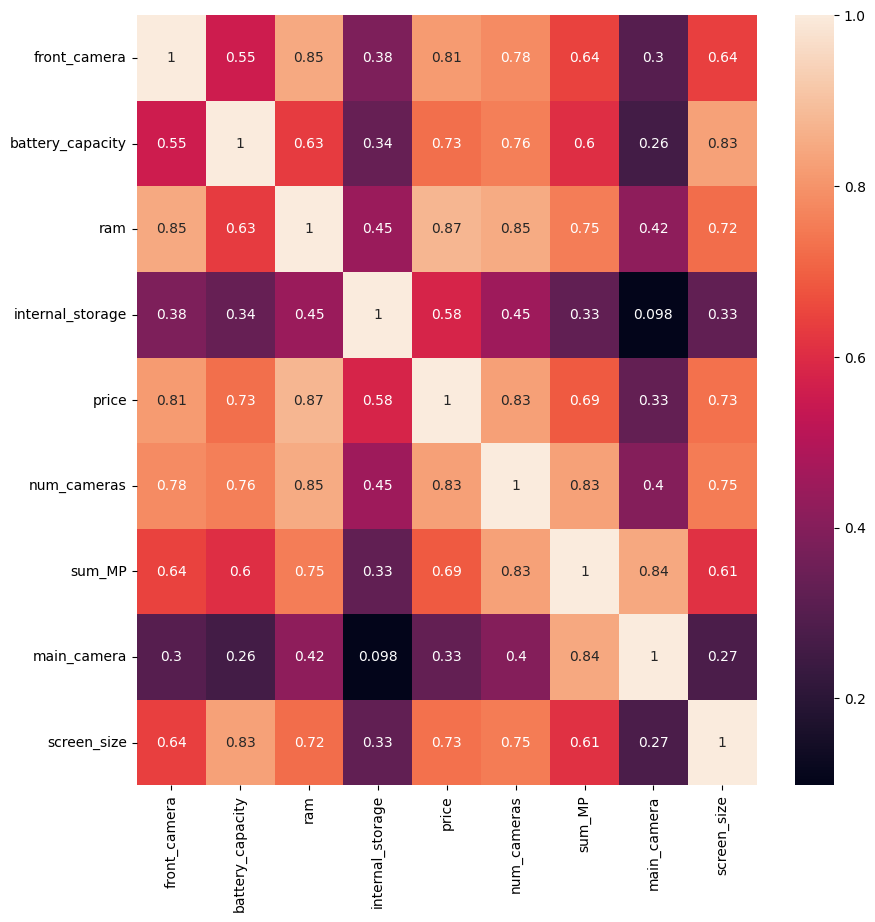

In [164]:
df

plt.figure(figsize=(10,10),dpi = 100)
sns.heatmap(df_apple.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11]].corr(),annot = df_apple.iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11]].corr())

## Użycie regresji liniowej

In [165]:
df_t = df.iloc[:, 3:-1]
df_t.describe

df_d = df_t.iloc[:, 3]
df_t = df_t.drop(columns = 'price')

print(df_t)
print('\n', df_d)

#for column in df_t.columns:
#    df_t[column] = df_t[column].apply(lambda x: x / max(df_t[column]))

opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df_t, df_d, test_size = 0.3)

X = opis_ucz.values
Y = dec_ucz.values.reshape(-1, 1)
x = opis_test.values
y = dec_test.values.reshape(-1, 1)

print(X.shape, Y.shape)

model = LinearRegression().fit(X, Y)

print(model.intercept_, model.coef_)

y_pred = model.predict(x)

print(opis_ucz['screen_size'])
print(y.size)
print(y_pred.size)

plt.scatter(df_t['screen_size'], df_d,  color='blue')
plt.plot(opis_test['screen_size'], y_pred, color='red', linewidth=3)
plt.show()

e = metrics.mean_squared_error(y, y_pred)
print(e)

              processor  battery_capacity  ram  internal_storage  num_cameras  \
0               Exynos               5000  8.0               128            4   
1               Exynos               4500  8.0               128            3   
2     Snapdragon 888 5G              4500  8.0               256            3   
3               Exynos               3700  8.0               128            3   
4               Exynos               5000  4.0                64            3   
...                 ...               ...  ...               ...          ...   
1250     Snapdragon 435              2900  3.0                32            1   
1251     Snapdragon 410              2630  2.0                16            1   
1253     Snapdragon 410              2000  1.0                 8            1   
1254      Dimensity 720              4300  8.0               128            3   
1255      Dimensity 720              4300  8.0               256            3   

      sum_MP  main_camera  

ValueError: could not convert string to float: 'Snapdragon 425'

In [ ]:
df_t = df.iloc[:, 3:-1]
df_t.describe

df_d = df_t.iloc[:, 3]
df_t = df_t.drop(columns = 'price')

print(df_t)
print('\n', df_d)
max_all = 0
for column in df_t.columns:
    column_max = df_t[column].max()
    max_all = max_all + column_max*column_max
    df_t[column] = df_t[column].apply(lambda x: x/column_max)
price_max = df_d.max()
df_d = df_d.apply(lambda x: x/price_max)

opis_ucz, opis_test, dec_ucz, dec_test = train_test_split(df_t, df_d, test_size = 0.3)

X = opis_ucz.values
Y = dec_ucz.values.reshape(-1, 1)
x = opis_test.values
y = dec_test.values.reshape(-1, 1)

print(X.shape, Y.shape)

model = LinearRegression().fit(X, Y)

print(model.intercept_, model.coef_)

y_pred = model.predict(x)

print(opis_ucz['screen_size'])
print(y.size)
print(y_pred.size)

plt.scatter(df_t['screen_size'], df_d,  color='blue')
plt.plot(opis_test['screen_size'], y_pred, color='red', linewidth = 3)
plt.show()

e = metrics.mean_squared_error(y, y_pred)
max_all = max_all + (price_max * price_max)
max_all = max_all**0.5
print(e*max_all)

                     rare_camera          processor  battery_capacity  ram  \
0     108MP + 10MP + 10MP + 12MP            Exynos               5000  8.0   
1             50MP + 10MP + 12MP            Exynos               4500  8.0   
2           12 MP + 8 MP + 12 MP  Snapdragon 888 5G              4500  8.0   
3             50MP + 10MP + 12MP            Exynos               3700  8.0   
4               50MP + 2MP + 2MP            Exynos               5000  4.0   
...                          ...                ...               ...  ...   
1250                       13 MP     Snapdragon 435              2900  3.0   
1251                        8 MP     Snapdragon 410              2630  2.0   
1253                        8 MP     Snapdragon 410              2000  1.0   
1254         48 MP + 8 MP + 2 MP      Dimensity 720              4300  8.0   
1255         48 MP + 8 MP + 2 MP      Dimensity 720              4300  8.0   

      internal_storage  num_cameras main_camera  screen_size  


TypeError: can't multiply sequence by non-int of type 'str'